In [1]:
import numpy as np
import skimage
import matplotlib.pyplot as plt
%matplotlib inline


from numpy.random import normal
import math
from scipy.optimize import curve_fit
from scipy.interpolate import RectBivariateSpline
from skimage import io
from skimage.data import shepp_logan_phantom
from skimage.transform import radon, rescale, rotate, iradon

In [2]:
def highest_non_zero_index(arr):
  # Find the highest index in the array that is non-zero
    l = len(arr) - 1
    while l > 0:
        if arr[l] != 0:
            return l
        l -= 1
    return l

In [3]:
def wasserstein_distance(hist1, hist2):
  # Normalize histograms
  hist1 = hist1 / np.sum(hist1)
  hist2 = hist2 / np.sum(hist2)

  # Calculate CDFs
  cdf1 = np.cumsum(hist1)
  cdf2 = np.cumsum(hist2)

  # Calculate Wasserstein distance
  W = np.sum(np.abs(cdf1 - cdf2))

  return W

In [4]:
def shift_array(x, n):
    if n == 0:
        return x
    elif n > 0:
        # Shift to the right
        return np.concatenate([np.zeros(n), x[:-n]])
    else:
        # Shift to the left
        n = abs(n)
        return np.concatenate([x[n:],np.zeros(n)])


In [5]:
def find_cusps(data, h):
    # Compute the derivative of the data using the difference quotient
    derivative = [(data[i+1] - data[i]) / h for i in range(len(data) - 1)]
    # Find points where the derivative is close to zero
    cusps = []
    for i, value in enumerate(derivative):
        if abs(value) < 0.01: 
            cusps.append(i)
 
    return cusps


In [6]:
def find_middle_values(lst):
    # Split the list into two sublists at the first occurrence of a gap of more than one element
    sublists = []
    current_sublist = []
    for i, value in enumerate(lst):
        if i > 0 and lst[i] - lst[i-1] > 1:
            sublists.append(current_sublist)
            current_sublist = []
        current_sublist.append(value)
    sublists.append(current_sublist)
 
    # Find the middle value of each sublist
    middle_values = []
    for sublist in sublists:
        middle_index = len(sublist) // 2
        middle_values.append(sublist[middle_index])
 
    return middle_values


In [7]:
def split_array(array, split_points):
    # Add the end of the array as a split point if it is not already in the list
    if split_points[-1] != len(array):
        split_points.append(len(array))
 
    # Split the array at each split point
    split_arrays = []
    start = 0
    for end in split_points:
        split_arrays.append(array[start:end])
        start = end
 
    return split_arrays


In [32]:
angle_frequency = 2 
theta = np.arange(0., 180., 1/angle_frequency)

class CT_Object ():
    
    def __init__(self,image):
        #Define the image
        self.image = image
        
        #xv and yv can be used to describe geometric objects
        _ = np.linspace(-1, 1, self.image.shape[0])
        self.xv, self.yv = np.meshgrid(_,_)
        
        #Define the sinogram
        self.sinogram = radon(self.image, theta=theta)
        
        #Define the reconstructed image
        self.recon = iradon(self.sinogram, theta=theta, filter_name='ramp')
        
        #Now let's define the upper shape function of a circle
        
        self.sin_up = np.zeros(len(theta))
        self.poly_up = np.zeros(len(theta))
        
    def update_sin_up(self):    
        for thet in theta:
            thet = int(angle_frequency*thet)
            self.sin_up[thet] = highest_non_zero_index(self.sinogram[:,thet])
        
    def curve_up(self):

        # Load the data from a file or generate it using some other method
        x_data = range(len(theta))
        y_data = self.sin_up

        # Define the sin curve function
        def sin_curve(X, a, b, c, d):
            x=X
            return a * np.sin(b * x + c) + d

        # Fit the curve to the data
        params = curve_fit(sin_curve, x_data, y_data, [30,1/100,200,100]) 


        # Get the fitted curve
        fitted_curve = sin_curve(x_data, params[0][0], params[0][1], params[0][2], params[0][3])


        # plot it
        #plt.plot(fitted_curve)
        #plt.plot(self.sin_up)

        #plt.ylim(0,200)
        # Show the plot
        #plt.show()
        return fitted_curve
        

    def fit_poly_up(self):

        for thet in theta:
            thet = int(2*thet)
            self.poly_up[thet] = highest_non_zero_index(self.sinogram[:,thet])
        
        
        x_data = range(len(theta))
        # Get the fitted curve
        params = np.polyfit(x_data, self.poly_up, deg=10)
        fitted_curve = np.polyval(params, x_data)

        
        cusps = find_cusps(fitted_curve,1)
        middle_values = find_middle_values(cusps)
        middle_values = [x for x in middle_values if x > 10]
        middle_values = [x for x in middle_values if x < len(theta) - 15]
        multiple_curves_y = split_array(self.poly_up, middle_values)
        multiple_curves_x = split_array(x_data, middle_values)
        
        new_curve = []
        
        for i in range(0,len(middle_values)):
            # Get the fitted curve for the current subarray
            params = np.polyfit(multiple_curves_x[i], multiple_curves_y[i], deg=2)
            new_curve = np.append(new_curve,np.polyval(params, multiple_curves_x[i]))

        #for i in range(80,100):
            #print(new_curve[i],i)
        
        for m in middle_values:
            # Check if m+1 is within the bounds of the array
            if m+1 < len(new_curve):
                d = new_curve[m-1] - new_curve[m]
                h = new_curve[m-1] - new_curve[m-2]
                d+=h
                #print("hiphuraaay",d, m)
            for i in range(m,len(new_curve)):
                # Check if i is within the bounds of the array
                if i < len(new_curve):
                    new_curve[i] += d

            
            
        #plot it
        plt.plot(fitted_curve)
        plt.plot(self.poly_up)
        plt.plot(new_curve)

        plt.ylim(0,300)
        # Show the plot
        plt.show()
        #for i in range(80,100):
            #print(new_curve[i], i)
        return new_curve        
        
        
    #add a circle or ellipse to the bare image
    def add_circ_im(self,x,y,r,f,a=1,b=1):
        self.image[((self.xv-x)/a)**2+((self.yv-y)/b)**2<r**2] = f
        
        #update sinogram and reconstruction
        self.sinogram = radon(self.image, theta=theta)
        self.recon = iradon(self.sinogram, theta=theta, filter_name='ramp')
        
        #filter low values
        for element in np.nditer(self.recon):
            element = int(element)
        
        #update
        self.update_sin_up()
    
    #plot the image
    def plot(self):
        plt.imshow(self.image)
    
    #plot the sinogram
    def plot_sin(self):
        plt.imshow(self.sinogram)
    
    #plot the reconstructed image
    def plot_rec(self):
        plt.imshow(self.recon)
            
    #add noise/pertubation to the sinogram
    def pert_sin(self,mu,sig2):
        for thet in theta:
                #w will be a normal i.i.d. additive noise, we then shift the whole column up or down by this amount
                w = int(normal(loc=mu, scale=sig2, size=1))
                self.sinogram[:,int(2*thet)] = shift_array(self.sinogram[:,int(2*thet)], w)

        #update the reconstruction
        self.recon = iradon(self.sinogram, theta=theta, filter_name='ramp')
    
    
    
    #add a rectangle to the bare image
    def add_rec_im(self,x,y,f,a,b):
        self.image[np.logical_and(np.absolute(self.xv-x)<a, np.absolute(self.yv-y)<b)] = f
        
        #update sinogram and reconstruction
        self.sinogram = radon(self.image, theta=theta)
        self.recon = iradon(self.sinogram, theta=theta, filter_name='ramp')
        
        #filter low values
        for element in np.nditer(self.recon):
            element = int(element)
        
        #update
        self.update_sin_up() 


    
    
    #recover the sinogram
    def rec_sin(self):
        a = self.curve_up()
        b = np.zeros(len(theta))
        for t in theta:
            b[int(2*t)] = highest_non_zero_index(self.sinogram[:,int(2*t)])
        c = a-b
        
        for thet in theta:
            self.sinogram[:,int(2*thet)] = shift_array(self.sinogram[:,int(2*thet)], round(c[int(2*thet)]))
        self.recon = iradon(self.sinogram, theta=theta, filter_name='ramp')

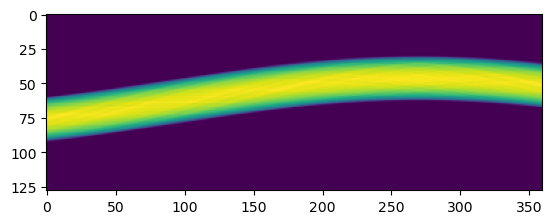

In [33]:
circle = CT_Object(np.zeros([128,128]))
circle.add_circ_im(0.2,0.2,0.25,1)
circle.plot_sin()

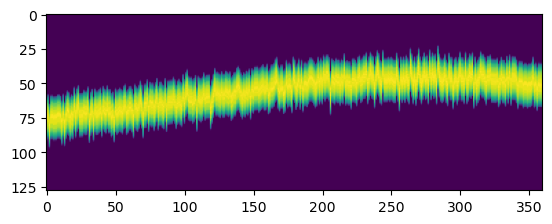

In [34]:
circle.pert_sin(0,3)
circle.plot_sin()

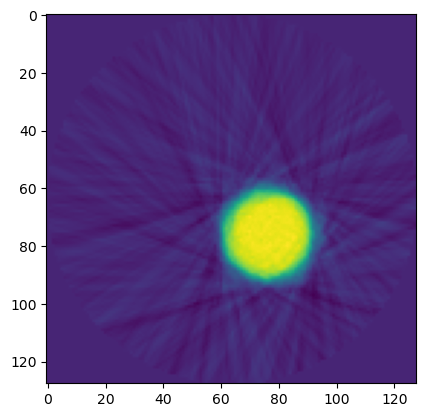

In [35]:
circle.plot_rec()

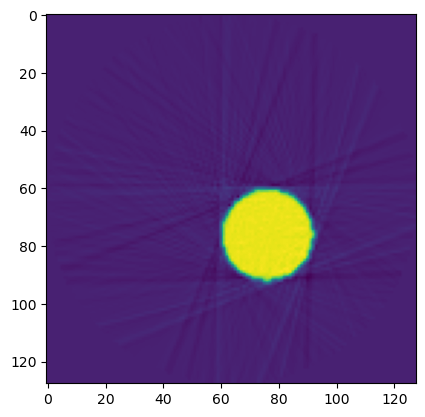

In [36]:
circle.rec_sin()
circle.plot_rec()

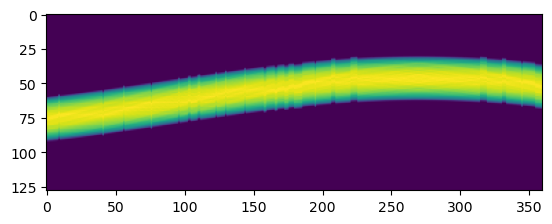

In [37]:
circle.plot_sin()

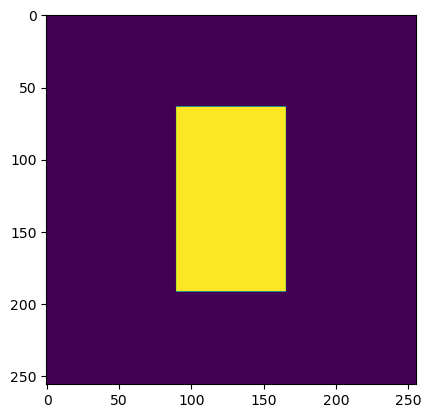

In [38]:
rec = CT_Object(np.zeros([256,256]))
rec.add_rec_im(0,0,5,0.3,0.5)
rec.plot()

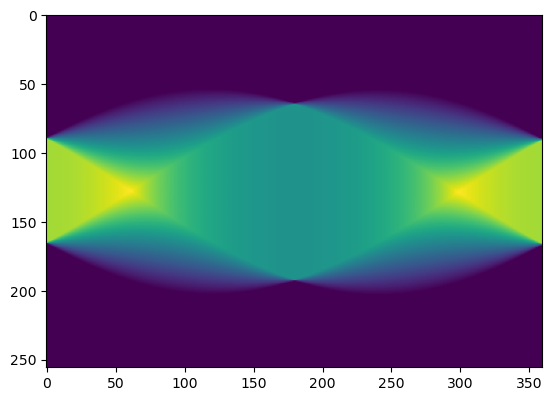

In [39]:
rec.plot_sin()

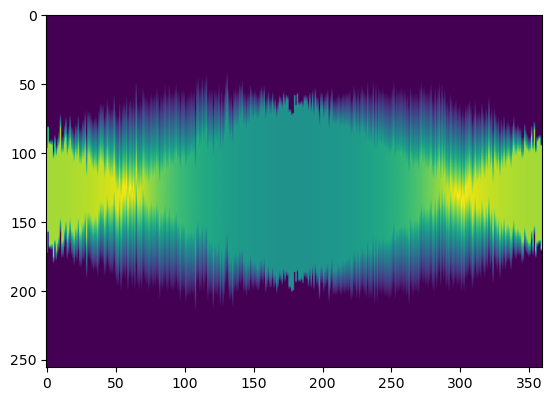

In [40]:
rec.pert_sin(0,5)
rec.plot_sin()

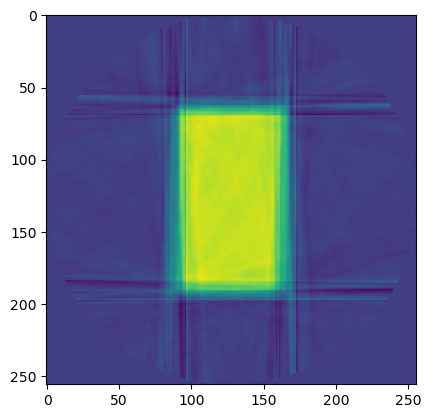

In [41]:
rec.plot_rec()

In [18]:
rec.rec_sin()
rec.plot_sin()

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.

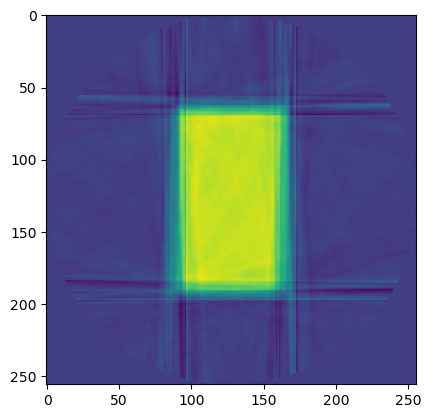

In [42]:
rec.plot_rec()

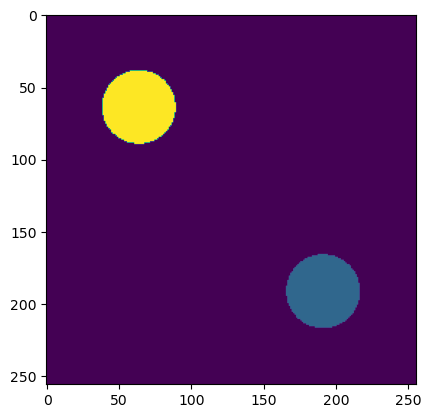

In [43]:
twocircles = CT_Object(np.zeros([256,256]))
twocircles.add_circ_im(0.5,0.5,0.2,1)
twocircles.add_circ_im(-0.5,-0.5,0.2,3)
twocircles.plot()

In [ ]:
twocircles.plot_sin()

In [ ]:
twocircles.pert_sin(0,5)
twocircles.plot_sin()

In [ ]:
twocircles.plot_rec()

In [ ]:
twocircles.rec_sin()
twocircles.plot_sin()

In [ ]:
twocircles.plot_rec()